# Create a General Simulation Model from a model_grid.csv and ibound.tif

Standard package imports

In [1]:
%matplotlib notebook

import os
import datetime as dt
import pickle, joblib


# Standard data science libraries
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.optimize as so 
import scipy.interpolate as si

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-notebook')

# Options for pandas
pd.options.display.max_columns = 20
pd.options.display.max_rows = 50

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import Image
from IPython.display import Math

Package imports specific to this notebook

In [2]:
import flopy as fp
import shutil
import Genmod_Utilities as gmu
import RTD_util6 as rtd_ut
from matplotlib import colors
from scipy.ndimage import distance_transform_edt
from argparse import Namespace
import json

In [3]:
with open('GenMod_metadata.txt') as json_file:
    metadata = json.load(json_file)

Set directory names to use

* **homes** is the root directory for the project
* **model** is the directory under the root that contains the GIS base for various scenarios.  It can correspond to a grid resolution
* **scenario_dir** is the subdirectory that contains the model run files for a particular set of inputs
* **mfpth6** is the relative path to the MODFLOW6 executable file

Create model workspace directory `model_ws`

In [4]:
if os.path.exists('model_ws'):
    shutil.rmtree('model_ws')
    os.makedirs('model_ws')
else:
    os.makedirs('model_ws')

Read `model_grid.csv` that was created in the first notebook

In [5]:
model_file = os.path.join(metadata['gis_dir'], 'model_grid.csv')
model_grid = pd.read_csv(model_file)
model_grid.fillna(0, inplace=True)

Set scenario specific model values and map hydrologic properties to columns in `model_grid`. These values are stored in a Python dictionary and saved for use in later notebooks.

* **num_surf_layers** : int, number of surficial (unconsolidated) aquifer layers

**Note that there should be at least 2 bedrock layers for the interpolation used in this method to work**

* **num_bdrk_layers** : int, number of bedrock layers
* **K_surf**: str, column in `model_grid` to map to surficial hydraulic conductivity
* **K_bdrk**: str, column in `model_grid` to map to bedrock hydraulic conductivity
* **ibound**: str, column in `model_grid` to map to idomain
* **GHB** : bool, whether to include general head boundary in lake cells on the model boundary
* **GHB_sea** : bool, whether to correct head at general head boundary for density
* **K_lakes** : float, hydraulic conductivity to set for bodies of open water (for example, lakes)
* **k33overk** : float, ratio of vertical to horizontal hydraulic conductivity
* **min_thk** : float, minimum thickness for the sum of all surficial layers
* **stream_bed_thk** : float, thickness of streambed used in calculating conductance
* **bedrock_thk** : float, thickness of bedrock
* **stream_bed_kadjust** : float, fraction of cell hydraulic conductivity used to calculate conductance in streams
* **coastal_sed_thk** : float, thickness of coastal sediments used in calculating conductance in coastal GHB
* **coastal_sed_kadjust** : float, fraction of cell hydraulic conductivity used to calculate conductance in coastal GHB
* **sea_level** : float, mean annual sea level
* **den_salt** : float, density of salt water
* **den_fresh** : float, density of fresh water
* **NPER** : int, number of stress periods
* **err_tol** : float, watertable elevation +/- err_tol is used to compute the objective function

In [6]:
gsm_metadata = dict(
num_surf_layers = 2,
num_bdrk_layers = 3,
K_surf = 'surf_K',
K_bdrk = 'bed_K',
ibound = 'ibound',
GHB = True,
GHB_sea = False,
K_lakes = 3000.,
k33overk = 0.1,
min_thk = 3.,
stream_bed_thk = 0.3,
surf_thk = 'thickness_Shang', 
bedrock_thk = 100.,
stream_bed_kadjust = 1.0,
coastal_sed_thk = 1.5,
coastal_sed_kadjust = 15.,
sea_level = 0 ,
den_salt = 1022 ,
den_fresh = 1000 ,
NPER = 1,
err_tol = 1.
)

dst = os.path.join('model_ws', 'gsm_metadata.json')
with open(dst, 'w') as f:
    json.dump(gsm_metadata, f, indent=4)   
    
meta = Namespace(**gsm_metadata)

In [7]:
model_grid.loc[model_grid[meta.K_bdrk] == 0, meta.ibound] = 0
model_grid.loc[model_grid[meta.K_surf] == 0, meta.ibound] = 0

## Map `model_grid` (created with Notebook 1) to MODFLOW6 arrays 

In [8]:
grid = os.path.join(metadata['gis_dir'], 'ibound.tif')
grid_raster = gmu.SourceProcessing(np.nan)
grid_raster.read_raster(grid)

NROW = grid_raster.nrow
NCOL = grid_raster.ncol
num_cells = NROW * NCOL

delr = np.abs(grid_raster.gt[1])
delc = np.abs(grid_raster.gt[5])

Model grid geometry

In [9]:
ibound = model_grid[meta.ibound].values.reshape(NROW, NCOL)
inactive = (ibound == 0)
top = model_grid.top.values.reshape(NROW, NCOL)
thick = model_grid.thickness_Shang.values.reshape(NROW, NCOL)

K for surficial and bedrock units.

In [10]:
surf_k = model_grid[meta.K_surf].values.reshape(NROW, NCOL) 
bdrk_k = model_grid[meta.K_bdrk].values.reshape(NROW, NCOL) 

## Process boundary condition information

Recharge

In [11]:
recharge = model_grid.recharge.values.reshape(NROW, NCOL)

Drains

Create a dictionary of stream information for the drain or river package.
River package input also needs the elevation of the river bed. Don't use both packages. The choice is made by commenting/uncommenting sections of the modflow function. Replace segment_len (segment length) with the conductance. The river package has not been tested.

In [12]:
drn_data = model_grid[(model_grid.order != 0) &
                      (model_grid.ibound == 1)].copy()

# adjust streambed K based on cell K and stream_bed_kadjust
drn_data['dcond'] = drn_data[meta.K_surf] * meta.stream_bed_kadjust * \
    drn_data.reach_len * drn_data.width / meta.stream_bed_thk 
drn_data['iface'] = 6

drn_data = drn_data.reindex(
    ['lay', 'row', 'col', 'stage', 'dcond', 'iface'], axis=1)
drn_data.rename(columns={'lay': 'k', 'row': 'i',
                         'col': 'j', 'stage': 'stage'}, inplace=True)

drn_data = drn_data[drn_data.dcond > 0]

# Convert to MODFLOW6 format
cellid = list(zip(drn_data.k, drn_data.i, drn_data.j))
drn_data6 = pd.DataFrame({'cellid': cellid, 'stage': drn_data.stage, 'dcond': drn_data.dcond, 'iface': drn_data.iface})
drn_recarray6 = drn_data6.to_records(index=False)
drn_dict6 = {0 : drn_recarray6}

General head boundary (GHB)

Create a dictionary of information for the general-head boundary package.
Similar to the above cell. 

In [13]:
if (model_grid.ghb_sea.sum() > 0) & meta.GHB:
    ghb_flag = model_grid.ghb == 1
    ghb_data = model_grid.loc[ghb_flag, :].copy()
    ghb_data['cond'] = ghb_data[meta.K_surf] * delc * delr / meta.stream_bed_thk
    ghb_data['iface'] = 6

    ghb_data = ghb_data.reindex(['lay', 'row', 'col', 'ned', 'cond', 'iface'], axis=1)

    ghb_data.rename(columns={'lay': 'k', 'row': 'i', 'col': 'j', 'ned': 'stage'}, inplace=True)
    
    ghb_data.dropna(axis='index', inplace=True)
    ghb_recarray = ghb_data.to_records(index=False)
    ghb_dict = {0 : ghb_recarray}

Marine general head boundary

Create a dictionary for the marine general-head boundary.

In [14]:
# if model_grid.ghb_sea.sum() > 0:
#     #currently the marine ghb would overwrite any existing ghb, therefore write an alert
#     if GHB & GHB_sea:
#         GHB = False
#         print("Code doesn't support multiple ghb's. Marine ghb will be implemented.")    
#     ghb_flag = model_grid.ghb_sea == 1
#     ghb_sea_data = model_grid.loc[ghb_flag, ['lay', 'row', 'col', 'fresh_head', 'segment_len', meta.K_surf]]
#     ghb_sea_data.columns = ['k', 'i', 'j', 'stage', 'segment_len', meta.K_surf]
#     gcond = ghb_sea_data[meeta.K_surf] * L * L / coastal_sed_thk / coastal_sed_kadjust
#     ghb_sea_data['segment_len'] = gcond
#     ghb_sea_data.rename(columns={'segment_len' : 'cond'}, inplace=True)
#     ghb_sea_data.drop(meta.K_surf, axis=1, inplace=True)
#     ghb_sea_data.dropna(axis='index', inplace=True)
#     ghb_sea_data.insert(ghb_sea_data.shape[1], 'iface', 6)
#     ghb_sea_recarray = ghb_sea_data.to_records(index=False)
#     ghb_sea_dict = {0 : ghb_sea_recarray}

### Create 1-layer model to get initial top-of-aquifer on which to drape subsequent layering

Get starting heads from top elevations. The top is defined as the model-cell-mean NED elevation except in streams, where it is interpolated between MaxElevSmo and MinElevSmo in the NHD (called 'stage' in model_grid). Make them a little higher than land so that drains don't accidentally go dry too soon.

Modify the bedrock surface, ensuring that it is always at least min_thk below the top elevation. This calculation will be revisited for the multi-layer case.

## Define a function to create and run MODFLOW6

In [15]:
def modflow(md, mfpth6, model_ws, nlay=1, top=top, strt=top, nrow=NROW, ncol=NCOL, botm=(top - thick),
            ibound=ibound, hk=surf_k, rech=recharge, stream_dict=drn_dict6, delr=delr, delc=delc,
            hnoflo=-9999., hdry=-8888., iphdry=1, vani=meta.k33overk):

    # Create the Flopy simulation object
    sim = fp.mf6.MFSimulation(sim_name=md, exe_name=mfpth6,
                              version='mf6', sim_ws=model_ws)

    # Create the Flopy temporal discretization object
    tdis = fp.mf6.modflow.mftdis.ModflowTdis(sim, pname='tdis', time_units='DAYS',
                                             nper=1, perioddata=[(1.0E+05, 1, 1.0)])

    # Create the Flopy groundwater flow (gwf) model object
    model_nam_file = '{}.nam'.format(md)
    gwf = fp.mf6.ModflowGwf(sim, modelname=md, newtonoptions='UNDER_RELAXATION', 
                            model_nam_file=model_nam_file, save_flows=True)

    # Create the Flopy iterative model solver (ims) Package object
    ims = fp.mf6.modflow.mfims.ModflowIms(
        sim, pname='ims', complexity='COMPLEX')

    # Create the discretization package
    dis = fp.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, pname='dis', nlay=nlay, nrow=NROW, ncol=NCOL, length_units='METERS',
                                                delr=delr, delc=delc, top=top, botm=botm, idomain=ibound)

    # Create the initial conditions package
    ic = fp.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname='ic', strt=strt)

    # Create the node property flow package
    npf = fp.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, pname='npf', icelltype=1, k=hk, k33=vani,
                                                k33overk=True, save_flows=True)

    rch = fp.mf6.modflow.mfgwfrcha.ModflowGwfrcha(
        gwf, recharge=rech, save_flows=True)

    drn = fp.mf6.modflow.mfgwfdrn.ModflowGwfdrn(
        gwf, stress_period_data=drn_dict6, save_flows=True)

    # Create the output control package
    headfile = '{}.hds'.format(md)
    head_filerecord = [headfile]
    budgetfile = '{}.cbb'.format(md)
    budget_filerecord = [budgetfile]
    saverecord = [('HEAD', 'ALL'),
                  ('BUDGET', 'ALL')]
    printrecord = [('HEAD', 'LAST')]
    
    oc = fp.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, pname='oc', saverecord=saverecord,
                                             head_filerecord=head_filerecord,
                                             budget_filerecord=budget_filerecord,
                                             printrecord=None)

    # Write the datasets
    sim.write_simulation(silent=False)

    # Run the simulation
    success, buff = sim.run_simulation(silent=False)
    
    if success:
        print('\nSuccess is sweet')
        print("    Your {:0d} layer model ran successfully\n\n".format(nlay))
    else:
        print('\nThat sucks')
        print("    Your {:0d} layer model didn't converge\n\n".format(nlay))

    return sim

## Run 1-layer MODFLOW

Use the function to run MODFLOW for 1 layer to getting approximate top-of-aquifer elevation

In [16]:
sim = modflow(metadata['HUC8_name'], metadata['modflow_path'], 'model_ws', nlay=1, top=top * 1.2, strt=top * 1.05, nrow=NROW, ncol=NCOL, botm=(top - thick - meta.bedrock_thk),
              ibound=ibound, hk=surf_k, rech=recharge, stream_dict=drn_dict6, delr=delr, delc=delc, iphdry=0, vani=meta.k33overk)

C:\Users\jjstarn\Miniconda3\envs\genmod20\lib\site-packages\flopy\mf6\data\mfdatalist.py:1688: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if "check" in list_item:


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model Saco...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 3797 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../Executables/mf6.1.1/bin/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.1 06/12/2020

   MODFLOW 6 compiled Jun 11 2020 17:47:19 with IFORT compiler (ver. 19.10.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant 

Read the head file and calculate new layer top (wt) and bottom (bot) elevations based on the estimated
water table (wt) being the top of the top layer. Divide the surficial layer into NLAY equally thick layers between wt and the bedrock surface elevation (as computed using minimum surficial thickness). 

Make new model with (possibly) multiple layers. If there are dry cells in the 1 layer model, they are converted to NaN (not a number). The minimum function in the first line returns NaN if the element of either input arrays is NaN.  In that case, replace NaN in modeltop with the top elevation. The process is similar to the 1 layer case. Thickness is estimated based on modeltop and bedrock and is constrained to be at least min_thk (set in gen_mod_dict.py). This thickness is divided into num_surf_layers number of layers. The cumulative thickness of these layers is the distance from the top of the model to the bottom of the layers. This 3D array of distances (the same for each layer) is subtracted from modeltop.

Using the estimated water table as the new top-of-aquifer elevations sometimes leads to the situation, in usually a very small number of cells, that the drain elevation is below the bottom of the cell.  The following procedure resets the bottom elevation to one meter below the drain elevation if that is the case. 

* If add_bedrock = True in gen_mod_dict.py, add a layer to the bottom and increment NLAY by 1.
* Assign the new bottom-most layer an elevation equal to the elevation of the bottom of the lowest surficial layer minus bedrock_thk, which is specified in rock_riv_dict (in gen_mod_dict.py).
* Concatenate the new bottom-of-bedrock-layer to the bottom of the surficial bottom array.
* Compute the vertical midpoint of each cell. Make an array (bedrock_index) that is True if the bedrock surface is higher than the midpoint and False if it is not.
* lay_extrude replaces the old lay_extrude to account for the new bedrock layer. It is not used in this cell, but is used later to extrude other arrays.

Extrude all arrays to NLAY number of layers. Create a top-of-aquifer elevation (fake_top) that is higher (20% in this case) than the simulated 1-layer water table because in doing this approximation, some stream elevations end up higher than top_of_aquifer and thus do not operate as drains. The fake_top shouldn't affect model computations if it is set high enough because the model uses convertible (confined or unconfined) layers.

Run MODFLOW again using the new layer definitions.  The difference from the first run is that the top-of-aquifer elevation is the 1-layer water table rather than land surface, and of course, the number of surficial layers and/or the presence of a bedrock layer is different. 

In [17]:
for i in range(2):
    rtd = rtd_ut.RTD_util(sim, 'flow', 'rt')
    rtd.get_watertable()
    wt = np.ma.masked_invalid(rtd.water_table)

    top_layer1 = np.minimum(wt, top)
    bedrock_top = top - thick
    thk = np.maximum(top_layer1 - bedrock_top, meta.min_thk)
    
    NLAY = meta.num_surf_layers + meta.num_bdrk_layers
    
    lay_extrude = np.ones((meta.num_surf_layers, NROW, NCOL))
    
    surf_thk = lay_extrude * thk / meta.num_surf_layers
    surf_elev_array = top_layer1 - np.cumsum(surf_thk, axis=0)
    surf_k_array = lay_extrude * surf_k

    lay_extrude = np.ones((meta.num_bdrk_layers, NROW, NCOL))
    
    bdrk_thk = lay_extrude * meta.bedrock_thk / meta.num_bdrk_layers
    bdrk_elev_array = surf_elev_array[-1, ...] - np.cumsum(bdrk_thk, axis=0)
    bdrk_k_array = lay_extrude * bdrk_k
    
    botm_array = np.vstack((surf_elev_array, bdrk_elev_array))
    lay_thk = np.vstack((surf_thk, bdrk_thk))
    hk_3d = np.vstack((surf_k_array, bdrk_k_array))

    lay_extrude = np.ones((NLAY, NROW, NCOL))
    stg = model_grid.stage.copy()
    stg[model_grid.order == 0] = 1.E+30
    tmpdrn = (lay_extrude * stg.values.reshape(NROW, NCOL)).ravel()
    tmpbot = botm_array.ravel()
    index = np.less(tmpdrn, tmpbot)
    tmpbot[index] = tmpdrn[index] - 1.0
    botm_array = tmpbot.reshape(NLAY, NROW, NCOL)

    mids = botm_array + lay_thk / 2
    bedrock_index = mids < bedrock_top

    la = model_grid.lake_areas.values.reshape(NROW, NCOL)
    
    # new way to calculate lake K
    frac_area = la / delr / delc
    hk_3d[0, ...] =  hk_3d[0, ...] * (1 - frac_area) +  meta.K_lakes * frac_area
    
    # next line is the original way to calculate lake K
#     hk_3d[0, la == 1] = K_lakes

    hk_3d[bedrock_index] = (lay_extrude * bdrk_k).astype(np.float32)[bedrock_index]
    
    ind = distance_transform_edt(hk_3d==0, return_distances=False, return_indices=True)
    hk_3d = hk_3d[tuple(ind)]

    strt_3d = (lay_extrude * top_layer1.data * 1.05).astype(np.float32)
    ibound_3d = (lay_extrude * ibound).astype(np.int16)
 
    dst = os.path.join('bedrock_flag_array.npz')
    np.savez(dst, bedrock_index=bedrock_index)

    sim = modflow(metadata['HUC8_name'], metadata['modflow_path'], 'model_ws', nlay=NLAY, top=top_layer1.data, strt=strt_3d, nrow=NROW, ncol=NCOL, 
            botm=botm_array, ibound=ibound_3d, hk=hk_3d, rech=recharge, stream_dict=drn_dict6, delr=delr, 
            delc=delc, hnoflo=-9999., hdry=-8888., iphdry=1, vani=meta.k33overk)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model Saco...
    writing model name file...
    writing package dis...


C:\Users\jjstarn\Miniconda3\envs\genmod20\lib\site-packages\flopy\mf6\data\mfdatalist.py:1688: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if "check" in list_item:


    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 3797 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../Executables/mf6.1.1/bin/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.1 06/12/2020

   MODFLOW 6 compiled Jun 11 2020 17:47:19 with IFORT compiler (ver. 19.10.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release 

C:\Users\jjstarn\Miniconda3\envs\genmod20\lib\site-packages\flopy\mf6\data\mfdatalist.py:1688: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if "check" in list_item:


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model Saco...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 3797 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../Executables/mf6.1.1/bin/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.1 06/12/2020

   MODFLOW 6 compiled Jun 11 2020 17:47:19 with IFORT compiler (ver. 19.10.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant 

Read the new head array and save it to a GeoTiff file.

<IPython.core.display.Javascript object>


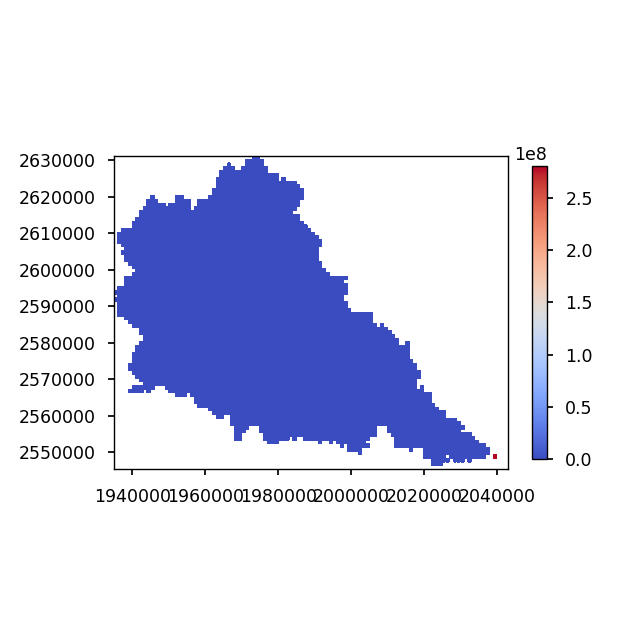

In [23]:
rtd = rtd_ut.RTD_util(sim, 'flow', 'rt')
rtd.get_watertable()
water_table = rtd.water_table
grid_raster.new_array = water_table

fig, ax = grid_raster.plot_raster(which_raster='new')
fig.set_tight_layout(True)
dst = os.path.join('precal-heads.tif')
grid_raster.write_raster(dst, which_raster='new')


Compute model errors

In [19]:
dif_wt = 1
hyd_wt = 1

t_crit = (model_grid.obs_type =='topo') & (ibound.ravel() != 0)
topo_cells = t_crit.values.reshape(NROW, NCOL)

h_crit = (model_grid.obs_type =='hydro') & (ibound.ravel() != 0)
hydro_cells = h_crit.values.reshape(NROW, NCOL)

num_topo = np.count_nonzero(topo_cells)
num_hydro = np.count_nonzero(hydro_cells)

topo = (top + meta.err_tol) < water_table
hydro = (top - meta.err_tol) > water_table

topo_error = topo & topo_cells
hydro_error = hydro & hydro_cells

t = np.count_nonzero(topo_error)
h = np.count_nonzero(hydro_error)

topo_rate = t / num_topo
hydro_rate = h / num_hydro

edif = dif_wt * np.abs(topo_rate - hydro_rate)
esum = topo_rate + hyd_wt * hydro_rate
target = -(edif + esum)

Plot a cross-section to see what the layers look like.  Change row_to_plot to see other rows.  Columns could be easily added.

<IPython.core.display.Javascript object>


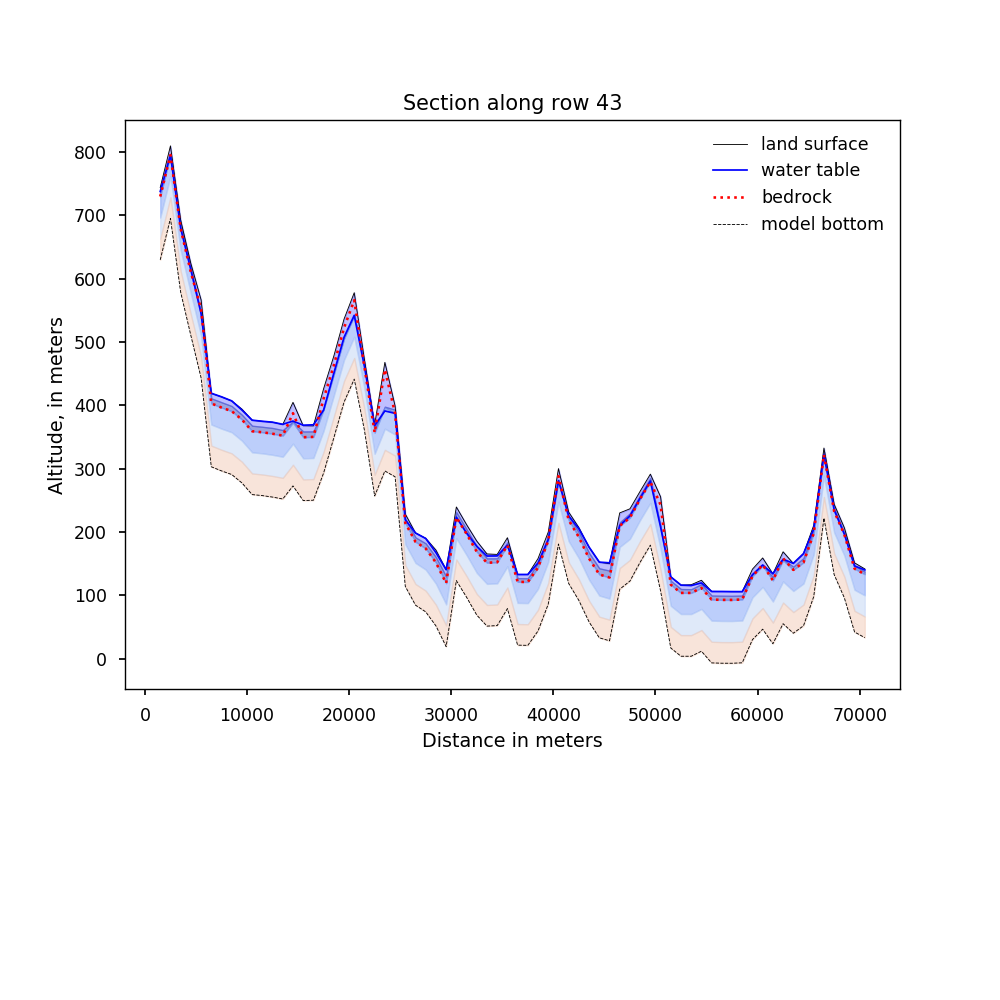

In [24]:
def ma2(data2D):
    return np.ma.MaskedArray(data2D, mask=inactive)


def ma3(data3D):
    return np.ma.MaskedArray(data3D, mask=(ibound_3d == 0))


def interpolate_travel_times(points, values, xi):
    return si.griddata(points, values, xi, method='linear')


def plot_travel_times(ax, x, y, tt, shp):
    with np.errstate(invalid='ignore'):
        return ax.contourf(x.reshape(shp), y.reshape(shp), tt[:].reshape(shp),
                           colors=colors, alpha=1.0, levels=levels, antialiased=True)


row_to_plot = np.int32(NROW / 2)
# row_to_plot = 65
xplot = np.linspace(delc / 2, NCOL * delc - delc / 2, NCOL)

mKh = ma3(hk_3d)
mtop = ma2(top)
mbed = ma2(bedrock_top)
mbot = ma3(botm_array)

# lay_colors = ['green', 'red', 'gray']
# make a color map of fixed colors
cmap = plt.cm.coolwarm
bounds = [0, 5, 10]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)

dum = ax1.plot(xplot, mtop[row_to_plot, ],
               label='land surface', color='black', lw=0.5)
dum = ax1.plot(xplot, rtd.water_table[row_to_plot, ],
               label='water table', color='blue', lw=1.)
dum = ax1.fill_between(xplot, mtop[row_to_plot, ], mbot[0, row_to_plot, :], alpha=0.25,
                       color='blue', lw=0.75)
for lay in range(NLAY-1):
    label = 'layer {}'.format(lay+2)
    dum = ax1.fill_between(xplot, mbot[lay, row_to_plot, :], mbot[lay+1, row_to_plot, :],
                           color=cmap(lay / NLAY), alpha=0.50, lw=0.75)
dum = ax1.plot(xplot, mbed[row_to_plot, :], label='bedrock',
               color='red', linestyle='dotted', lw=1.5)
dum = ax1.plot(xplot, mbot[-1, row_to_plot, :], color='black',
               linestyle='dashed', lw=0.5, label='model bottom')

# , bbox_to_anchor=(1.0, 0.5))
dum = ax1.legend(loc=0, frameon=False, fontsize=10, ncol=1)
dum = ax1.set_ylabel('Altitude, in meters')
# dum = ax1.set_xticklabels('')
dum = ax1.set_title('Section along row {}'.format(row_to_plot))

# ax2 = plt.subplot2grid((4, 1), (3, 0))
# dum = ax2.fill_between(xplot, 0, mKh[0, row_to_plot, :], alpha=0.25, color='blue',
#                  label='layer 1', lw=0.75, step='mid')
dum = ax1.set_xlabel('Distance in meters')
# dum = ax2.set_yscale('log')
# dum = ax2.set_ylabel('Hydraulic conductivity\n in layer 1, in meters / day')

line = '{}_xs.png'.format(metadata['HUC8_name'])
fig_name = os.path.join(line)
plt.savefig(fig_name)

<IPython.core.display.Javascript object>


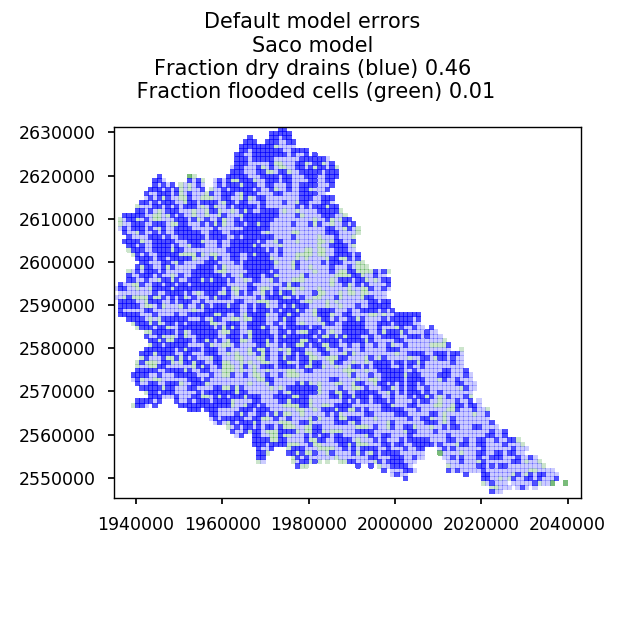

In [45]:
grid = os.path.join(metadata['gis_dir'], 'ibound.tif')
mtg = gmu.SourceProcessing(np.nan)
mtg.read_raster(grid)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

mask = (ibound == 0) | ~topo_cells
mt = np.ma.MaskedArray(topo_cells, mask)
cmap = colors.ListedColormap(['green'])
im = ax.pcolormesh(mtg.x_edge, mtg.y_edge, mt, cmap=cmap, alpha=0.2, edgecolors=None)
mask = (ibound == 0) | ~topo_error
mte = np.ma.MaskedArray(topo_error, mask)
cmap = colors.ListedColormap(['green'])
# dum = ax[0].imshow(mte, cmap=cmap)
im = ax.pcolormesh(mtg.x_edge, mtg.y_edge, mte, cmap=cmap, alpha=0.4, edgecolors=None)

mask = (ibound == 0) | ~hydro_cells
mh = np.ma.MaskedArray(hydro_cells, mask)
cmap = colors.ListedColormap(['blue'])
im = ax.pcolormesh(mtg.x_edge, mtg.y_edge, mh, cmap=cmap, alpha=0.2, edgecolors=None)
mask = (ibound == 0) | ~hydro_error
mhe = np.ma.MaskedArray(hydro_error, mask)
cmap = colors.ListedColormap(['blue'])
im = ax.pcolormesh(mtg.x_edge, mtg.y_edge, mhe, cmap=cmap, alpha=0.6, edgecolors=None)

ax.set_aspect(1)

dum = fig.suptitle('Default model errors\n{} model\nFraction dry drains (blue) {:0.2f}\n \
Fraction flooded cells (green) {:0.2f}'.format( \
 metadata['HUC8_name'], hydro_rate, topo_rate))
fig.set_tight_layout(True)

line = '{}_error_map.png'.format(metadata['HUC8_name'])   #csc
fig_name = os.path.join(line)
plt.savefig(fig_name)